In [19]:
# imports
import torch 
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torchvision.datasets as datasets # Standard datasets
from torch.utils.data import Dataset # Gives easier dataset management and creates mini batches
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.autograd import Variable



In [20]:
df = pd.read_csv('AirPassengers.csv')

# information about the data
print(df.head())
print(df.info())


     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


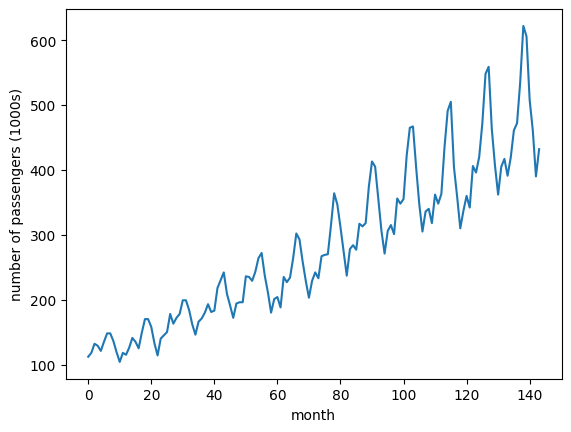

In [21]:
training_set = df.iloc[:,1:2].values
plt.xlabel('month')
plt.ylabel('number of passengers (1000s)')
plt.plot(training_set)
plt.show()



In [46]:

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)
training_data.shape


# create sequences
seq_length = 5
x = []
y = []
for i in range(len(training_data)-seq_length-1):
    
    x.append(training_data[i:i+seq_length])
    y.append(training_data[i+seq_length])
   

In [47]:
# Use gpu if available
device = torch.device('mps')

In [48]:
train_size = int(len(y) * 0.7) # 70% of the data is used for training
test_size = len(y) - train_size # 30% of the data is used for testing


dataX = torch.Tensor(np.array(x)).float() # convert to tensors
dataY = torch.Tensor(np.array(y)).float() # convert to tensors

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))
testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))



In [76]:
# Set hyperparameters for BI-LSTM and also LSTM
input_size = 1
hidden_size = 2
num_layers = 2
num_classes = 1
num_epochs = 2000
learning_rate = 0.01


# build class Bi LSTM 
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()


        self.input_size = input_size
        self.hidden_size = hidden_size

        # Because number of layers is 1, we can use the same number of layers for the forward and backward LSTM
        # But if you want Bi-stack LSTM, you can update the number of layers for the forward and backward LSTM
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.bilstm = nn.LSTM(input_size=input_size,  hidden_size=hidden_size,  num_layers=num_layers, batch_first=True, bidirectional=True)

        # Because this is a bidirectional LSTM, the input size for the fully connected layer is 2*hidden_size
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
            
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 


             # Propagate input through LSTM
            out, _ = self.bilstm(x, (h0, c0))
            out = out[:, -1, :]
            out = self.fc(out)
            return out
    





class StackLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(StackLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.lstm = nn.LSTM(input_size=input_size,  hidden_size=hidden_size,  num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
            
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
             # Propagate input through LSTM
            out, _ = self.lstm(x, (h0, c0))
            out = out[:, -1, :]
            out = self.fc(out)
            return out
    

In [77]:



# lstm = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
lstm = StackLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
# BiLSTM
#lstm = BiLSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [78]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


In [79]:


# train network 
for epoch in range(num_epochs):
    outputs = lstm(trainX.to(device))  # Move input data to GPU
    optimizer.zero_grad()

    loss = criterion(outputs, trainY.to(device)) # Move target data to GPU
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


Epoch: 0, loss: 0.52587
Epoch: 100, loss: 0.01889
Epoch: 200, loss: 0.00363
Epoch: 300, loss: 0.00248
Epoch: 400, loss: 0.00197
Epoch: 500, loss: 0.00181
Epoch: 600, loss: 0.00173
Epoch: 700, loss: 0.00170
Epoch: 800, loss: 0.00167
Epoch: 900, loss: 0.00166
Epoch: 1000, loss: 0.00165
Epoch: 1100, loss: 0.00164
Epoch: 1200, loss: 0.00162
Epoch: 1300, loss: 0.00160
Epoch: 1400, loss: 0.00158
Epoch: 1500, loss: 0.00156
Epoch: 1600, loss: 0.00154
Epoch: 1700, loss: 0.00152
Epoch: 1800, loss: 0.00150
Epoch: 1900, loss: 0.00148


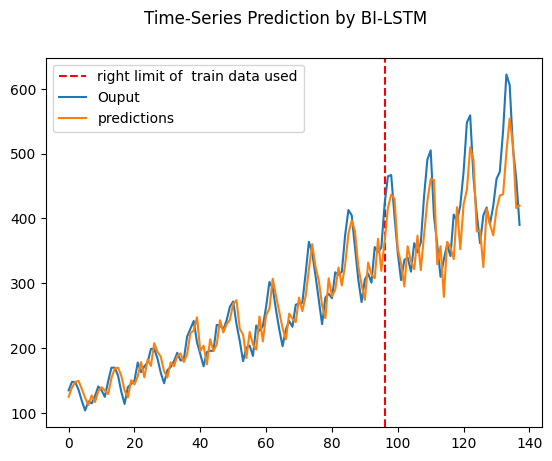

In [56]:
lstm.eval()

# predict on training and test data
all_predict = lstm(dataX.to(device)).cpu()

data_predict = all_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of  train data used')

plt.plot(dataY_plot, label='Ouput')
plt.plot(data_predict, label='predictions')
plt.suptitle('Time-Series Prediction by BI-LSTM')
plt.legend()
plt.show()
     

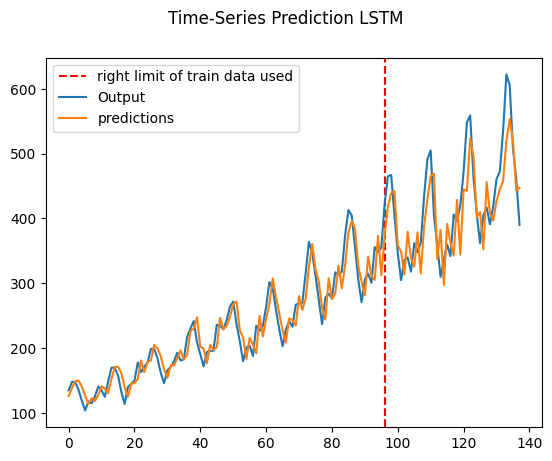

In [60]:
lstm.eval()

# predict on training and test data
all_predict = lstm(dataX.to(device)).cpu()

data_predict = all_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of train data used')

plt.plot(dataY_plot, label='Output')
plt.plot(data_predict, label='predictions')
plt.suptitle('Time-Series Prediction LSTM')
plt.legend()
plt.show()
     

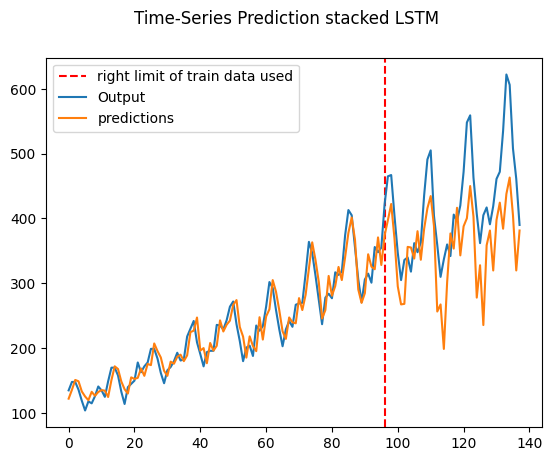

In [80]:
lstm.eval()

# predict on training and test data
all_predict = lstm(dataX.to(device)).cpu()

data_predict = all_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of train data used')

plt.plot(dataY_plot, label='Output')
plt.plot(data_predict, label='predictions')
plt.suptitle('Time-Series Prediction stacked LSTM')
plt.legend()
plt.show()
     

# stock

In [81]:
data = pd.read_csv('Data.csv')

In [82]:
data

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,1980-12-12,0.513393,0.515625,0.513393,-0.998061,0.406782,117258400
1,1,1980-12-15,0.488839,0.488839,0.486607,-0.998225,0.385558,43971200
2,2,1980-12-16,0.453125,0.453125,0.450893,-0.998444,0.357260,26432000
3,3,1980-12-17,0.462054,0.464286,0.462054,-0.998375,0.366103,21610400
4,4,1980-12-18,0.475446,0.477679,0.475446,-0.998293,0.376715,18362400
...,...,...,...,...,...,...,...,...
9904,9904,2020-03-26,246.520004,258.679993,246.360001,0.579454,258.440002,63021800
9905,9905,2020-03-27,252.750000,255.869995,247.050003,0.514011,247.740005,51054200
9906,9906,2020-03-30,250.740005,255.520004,249.399994,0.557252,254.809998,41994100
9907,9907,2020-03-31,255.600006,262.489990,252.000000,0.554072,254.289993,49250500


In [83]:
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(prices_scaled) * 0.8)
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size:]

# Hàm tạo dữ liệu cho mô hình
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Độ dài của cửa sổ dữ liệu
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Chuyển dữ liệu sang định dạng tensor của PyTorch
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [84]:

# Định nghĩa mô hình stacked LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Thiết lập các siêu tham số
input_size = 1
hidden_size = 100
output_size = 1
num_layers = 2
num_epochs = 100
learning_rate = 0.001

# Khởi tạo mô hình
device = torch.device('mps')
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)

# Định nghĩa hàm mất mát và bộ tối ưu hóa
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Huấn luyện mô hình
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0019
Epoch [20/100], Loss: 0.0018
Epoch [30/100], Loss: 0.0017
Epoch [40/100], Loss: 0.0016
Epoch [50/100], Loss: 0.0014
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


In [85]:
# Đánh giá mô hình trên tập kiểm tra
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.to(device))
    test_loss = criterion(test_outputs, y_test.to(device))
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0046


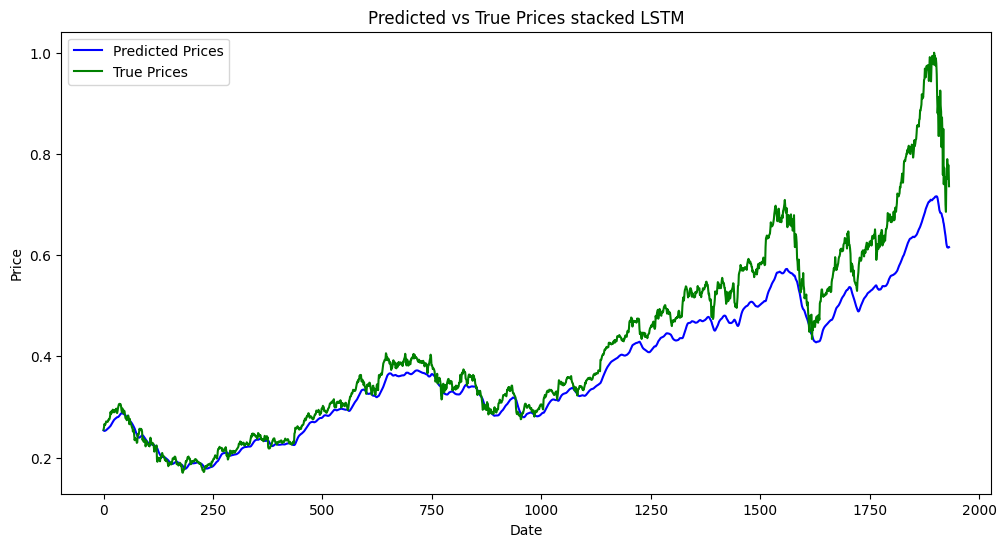

In [86]:
import matplotlib.pyplot as plt

# Chuyển dữ liệu dự đoán từ GPU về CPU
test_outputs_cpu = test_outputs.cpu()

# Chuyển dữ liệu dự đoán về dạng numpy array
predicted_prices = test_outputs_cpu.numpy()

# Chuyển dữ liệu giá trị thực tế về dạng numpy array
true_prices = y_test.cpu().numpy()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(predicted_prices, label='Predicted Prices', color='blue')
plt.plot(true_prices, label='True Prices', color='green')
plt.title('Predicted vs True Prices stacked LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [87]:

# Định nghĩa mô hình StackedLSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    


# Thiết lập các siêu tham số
input_size = 1
hidden_size = 100
output_size = 1
num_layers = 1
num_epochs = 100
learning_rate = 0.001

# Khởi tạo mô hình
device = torch.device('mps')
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)

# Định nghĩa hàm mất mát và bộ tối ưu hóa
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Huấn luyện mô hình
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0034
Epoch [20/100], Loss: 0.0018
Epoch [30/100], Loss: 0.0016
Epoch [40/100], Loss: 0.0015
Epoch [50/100], Loss: 0.0013
Epoch [60/100], Loss: 0.0012
Epoch [70/100], Loss: 0.0010
Epoch [80/100], Loss: 0.0007
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0000


In [88]:
# Đánh giá mô hình trên tập kiểm tra
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.to(device))
    test_loss = criterion(test_outputs, y_test.to(device))
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0211


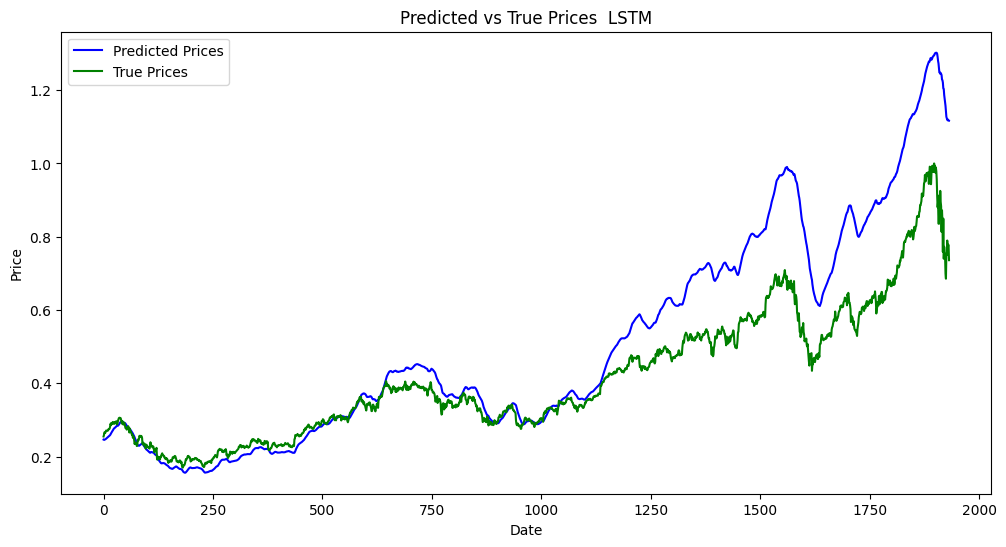

In [91]:
import matplotlib.pyplot as plt

# Chuyển dữ liệu dự đoán từ GPU về CPU
test_outputs_cpu = test_outputs.cpu()



# Chuyển dữ liệu dự đoán về dạng numpy array
predicted_prices = test_outputs_cpu.numpy()

# Chuyển dữ liệu giá trị thực tế về dạng numpy array
true_prices = y_test.cpu().numpy()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
# plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of  train data used')
plt.plot(predicted_prices, label='Predicted Prices', color='blue')
plt.plot(true_prices, label='True Prices', color='green')
plt.title('Predicted vs True Prices LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

7927

In [93]:

# Định nghĩa mô hình BiLSTM

# build class Bi LSTM 
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()


        self.input_size = input_size
        self.hidden_size = hidden_size

        # Because number of layers is 1, we can use the same number of layers for the forward and backward LSTM
        # But if you want Bi-stack LSTM, you can update the number of layers for the forward and backward LSTM
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.bilstm = nn.LSTM(input_size=input_size,  hidden_size=hidden_size,  num_layers=num_layers, batch_first=True, bidirectional=True)

        # Because this is a bidirectional LSTM, the input size for the fully connected layer is 2*hidden_size
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
            
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 


             # Propagate input through LSTM
            out, _ = self.bilstm(x, (h0, c0))
            out = out[:, -1, :]
            out = self.fc(out)
            return out
    

# Thiết lập các siêu tham số
input_size = 1
hidden_size = 100
output_size = 1
num_layers = 1
num_epochs = 100
learning_rate = 0.001

# Khởi tạo mô hình
device = torch.device('mps')
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)

# Định nghĩa hàm mất mát và bộ tối ưu hóa
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Huấn luyện mô hình
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0015
Epoch [20/100], Loss: 0.0011
Epoch [30/100], Loss: 0.0001
Epoch [40/100], Loss: 0.0001
Epoch [50/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


In [94]:
# Đánh giá mô hình trên tập kiểm tra
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.to(device))
    test_loss = criterion(test_outputs, y_test.to(device))
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0005


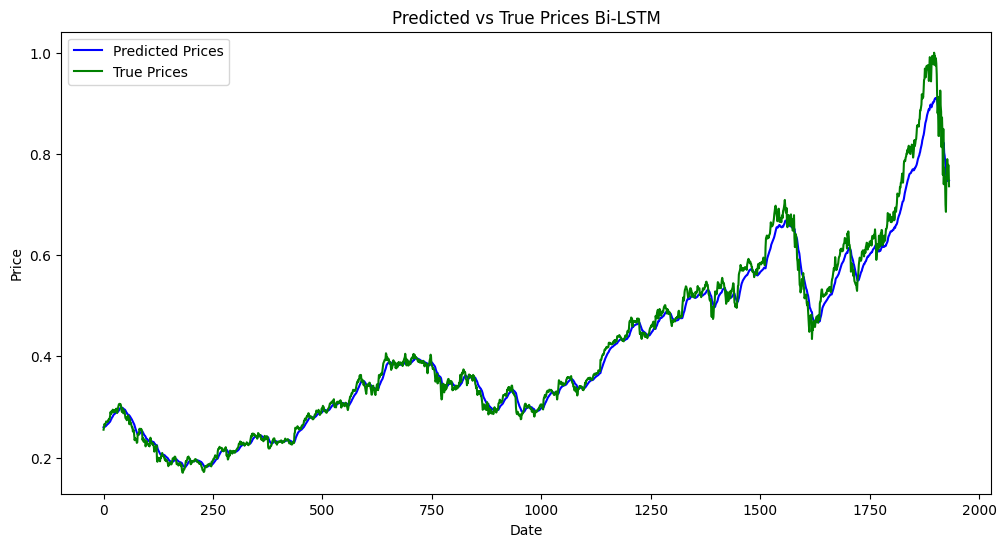

In [96]:
import matplotlib.pyplot as plt

# Chuyển dữ liệu dự đoán từ GPU về CPU
test_outputs_cpu = test_outputs.cpu()

# Chuyển dữ liệu dự đoán về dạng numpy array
predicted_prices = test_outputs_cpu.numpy()

# Chuyển dữ liệu giá trị thực tế về dạng numpy array
true_prices = y_test.cpu().numpy()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(predicted_prices, label='Predicted Prices', color='blue')
plt.plot(true_prices, label='True Prices', color='green')
plt.title('Predicted vs True Prices Bi-LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()